In [ ]:
import glob
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from typing import Callable, Optional
from  torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py 
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/triplet_loss.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/eval.py

--2021-05-25 10:00:13--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9770 (9.5K) [text/plain]
Saving to: ‘model.py.1’

model.py.1          100%[===================>]   9.54K  --.-KB/s    in 0s      

2021-05-25 10:00:13 (74.1 MB/s) - ‘model.py.1’ saved [9770/9770]

--2021-05-25 10:00:13--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385 (1.4K) [text/plain]
Saving to: ‘datasets.py.2’


In [ ]:
import triplet_loss
from model import ResNet
from datasets import AttDataset, YaleDataset
from eval import calculate_metrics, evaluate

In [ ]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19


In [ ]:
def Triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data


In [ ]:
# !cp -avr '/content/drive/MyDrive/Colab Notebooks/att_face_dataset' '/content/drive/MyDrive/Colab Notebooks/att_train'

In [ ]:
process = transforms.Compose([
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

## Train Data

In [ ]:
train_data = AttDataset(path='/content/drive/MyDrive/Colab Notebooks/att_train', 
                        transform=process)
train_data

Dataset AttDataset
    Number of datapoints: 350
    Root location: /content/drive/MyDrive/Colab Notebooks/att_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

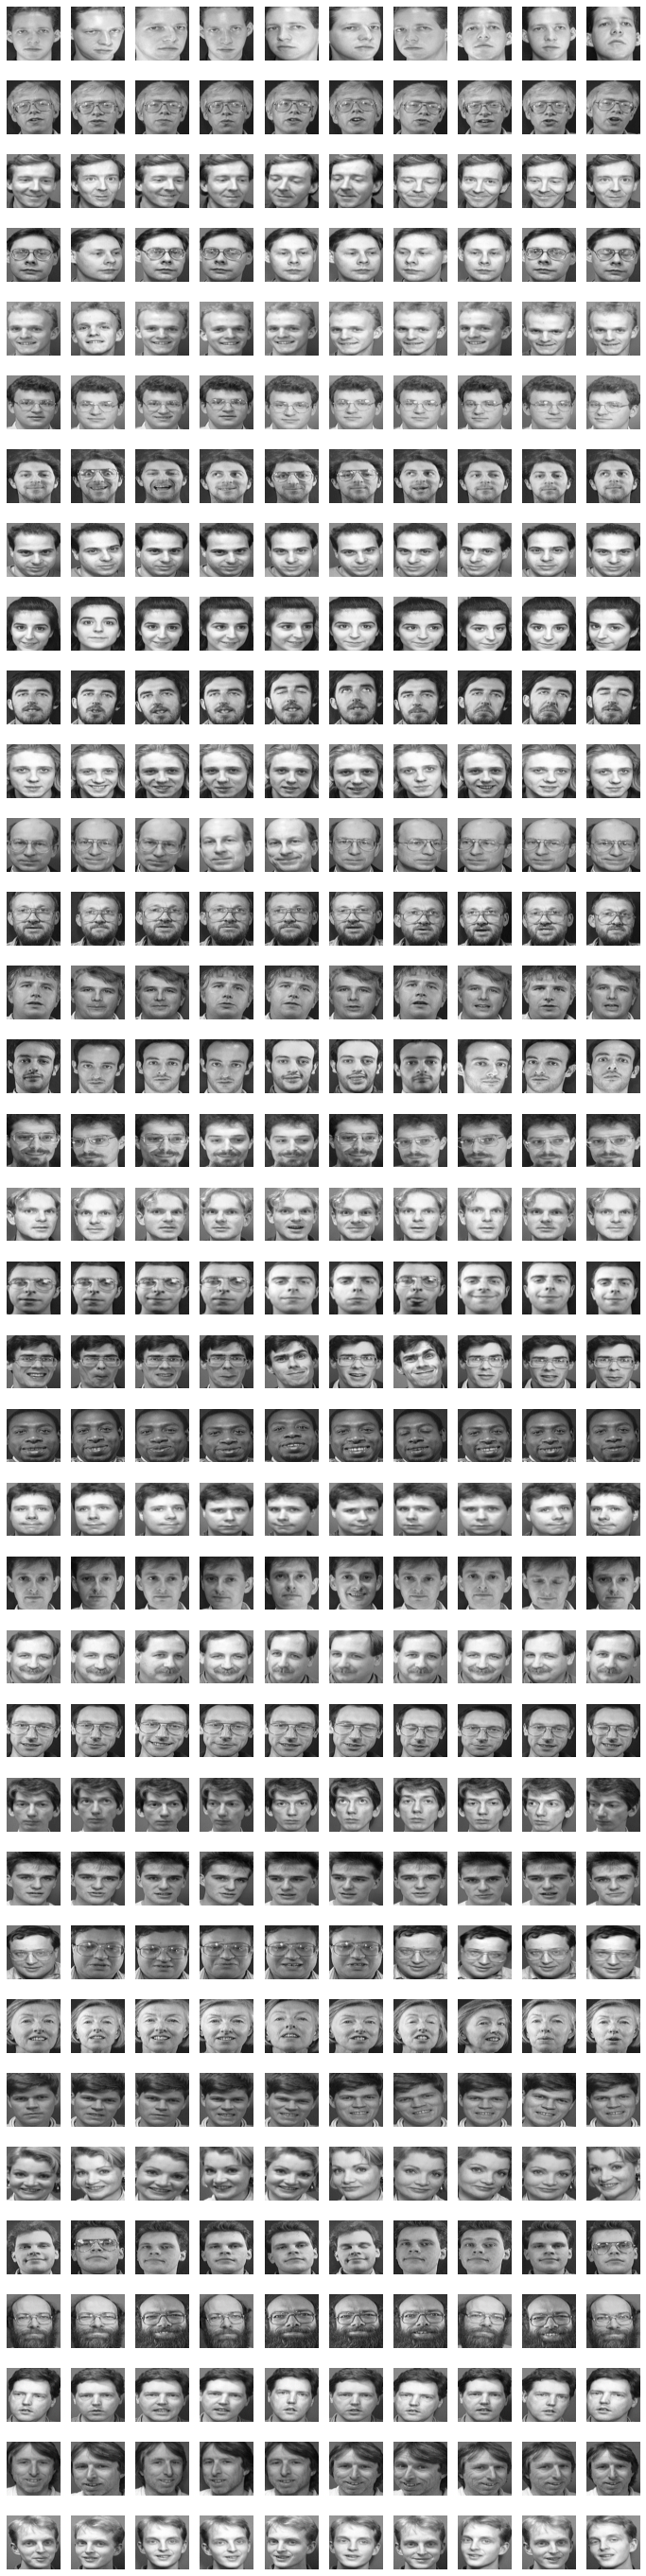

In [ ]:
_,axxr = plt.subplots(35,10, figsize=(12,50))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(train_data[i][0].squeeze(), cmap="gray")
    ax.axis('off')
plt.axis('off')
plt.savefig("train_data.png", dpi=300)
plt.show()

## Test Data

In [ ]:
# Ref : http://vision.ucsd.edu/content/yale-face-database
'''
!wget http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
!unzip yalefaces.zip

import os, shutil, glob
for i in range(1,16):
    files = glob.glob(f'yalefaces/subject{i:02d}*')
    for f in files:
        des = f'yalefaces/subject{i:02d}'
        if not os.path.exists(des):
            os.makedirs(des)
        shutil.move(f, des)
'''

In [ ]:
test = AttDataset(
    path = "/content/drive/MyDrive/Colab Notebooks/att_test" ,
    transform = process
)
test

Dataset AttDataset
    Number of datapoints: 50
    Root location: /content/drive/MyDrive/Colab Notebooks/att_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

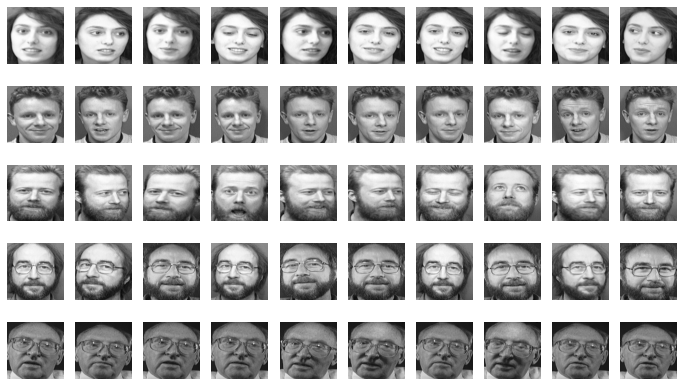

In [ ]:
_,axxr = plt.subplots(5,10, figsize=(12,7))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(test[i][0].squeeze(), cmap="gray")
    ax.axis('off')
plt.axis('off')
plt.savefig("test_data.png", dpi=300)
plt.show()

In [ ]:
# ax = plt.subplot()
# ax.imshow(test[3][0].squeeze(), cmap='gray')
# for spine in ax.spines.values():
#     spine.set_color("red")
# ax.set_xticks([])
# ax.set_yticks([])

# plt.show()

In [ ]:
# _,axxr = plt.subplots(15,11, figsize=(18,27))
# for i, ax in enumerate(axxr.flatten()):
#     ax.imshow(test[i][0].squeeze(), cmap="gray")
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.savefig('test_data.png', dpi=300)
# plt.show()

In [ ]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 40.),
                 fontdict={'weight': 'heavy', 'size': 10})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid()
    plt.title(title)
    return fig

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embeddings.detach().numpy())
fig = plot_embedding(reduced, labels.detach().numpy(),'t-SNE embedding of faces')

# W&B 

In [ ]:
!pip install wandb
!wandb login --relogin

In [ ]:
import wandb
# 1. Start a new run
wandb.init(project="Face-Unlock")

wandb: Currently logged in as: abd1 (use `wandb login --relogin` to force relogin)


In [ ]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.batch_size = 100
config.epochs = 100
config.learning_rate = 0.0002
config.fc_layer_size = 64
config.classes = 35
config.train_dataset = "AttDataset"
config.test_dataset = "AttDataset"
config.architechture = "ResNet18"

## Model

In [ ]:
resnet18 = ResNet(num_classes=config.fc_layer_size)
# resnet18 = torchvision.models.resnet18(num_classes=config.fc_layer_size)
# resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.to(device)

In [ ]:
loader = torch.utils.data.DataLoader(train_data, batch_size = config.batch_size, shuffle=True)
optimizer18 = optim.Adam(resnet18.parameters(), lr = config.learning_rate)
# scheduler18 = optim.lr_scheduler.ReduceLROnPlateau(optimizer18, factor=0.5, patience=2, min_lr=0.00001, verbose=True)
torch_triplet_loss = nn.TripletMarginLoss()

In [ ]:
image, label = next(iter(loader))
image.shape, label.shape

(torch.Size([40, 1, 224, 224]), torch.Size([40]))

In [ ]:
wandb.watch(resnet18, criterion='TripletLoss', log='all')

## Training Loop

In [ ]:
resnet18.train()
epochs_loss =[]
for epoch in range(config.epochs):
    epoch_loss = 0
    for step, (images, labels) in enumerate(loader):
        print(f"Epoch: {epoch:02d}, Step: {step:02d},", end=" ")
        start_time = time.time()

        embds = resnet18(images.to(device)).to('cpu')

        loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
        epoch_loss += loss.item()
        wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt})
        print(f"Loss: {loss.item():.3f}, +ve triplets: {fpt:.2f},", end=" ")

        optimizer18.zero_grad()
        loss.backward()
        optimizer18.step()

        current_time = time.time()
        print("Time: {:.4f}s".format(current_time-start_time))
    wandb.log({"epoch_loss": epoch_loss/config.batch_size})
    epochs_loss.append(epoch_loss/config.batch_size)

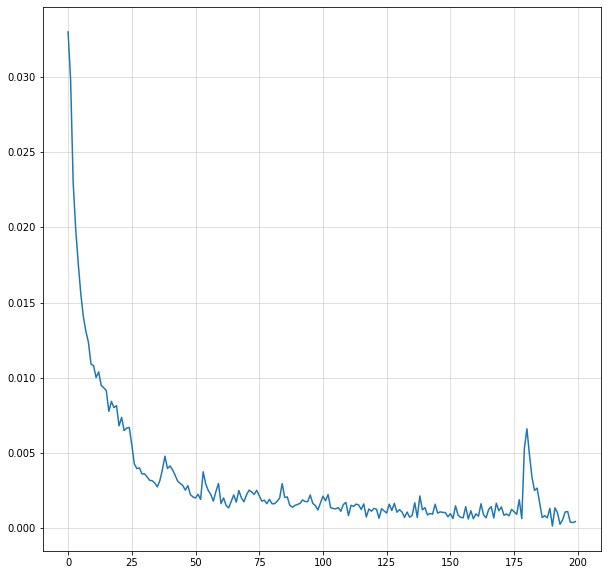

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epochs_loss, label="EpochLoss")
plt.grid(alpha=0.5)
plt.savefig("EpochLoss", dpi=200)
plt.show()

In [ ]:
torch.save(resnet18.state_dict(), "/content/drive/MyDrive/Colab Notebooks/facenet(64)6_checkpoint2.pth")

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/facenet(64)6_checkpoint2.pth"
resnet18 = ResNet(num_classes=64)
resnet18.to(device)
# resnet18.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
resnet18.load_state_dict(torch.load(path))
resnet18.eval()

```py
torch.save(resnet18, "/content/drive/MyDrive/Colab Notebooks/FaceNet_ATTdataset_best_model.pth")
```
Link to the model: [GDrive](https://drive.google.com/file/d/1BBlul3mdO3lZxWqiJHA0VmzjXAOTDxLw/view?usp=sharing)

In [ ]:
resnet18 = torch.load("/content/drive/MyDrive/Colab Notebooks/FaceNet_ATTdataset_best_model.pth")
resnet18.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

## Validation

In [ ]:
resnet18.eval()

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1).pow(.5)

tensor(0.8716, grad_fn=<PowBackward0>)


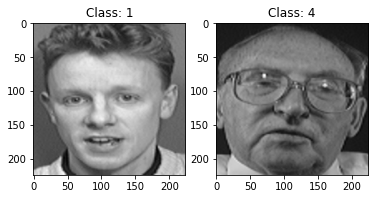

In [ ]:
_,(i1,i2) = plt.subplots(1,2)

img1 = test[11]#[0]
img2 = test[48]#[0]

i1.imshow(img1[0].squeeze(), cmap='gray')
i1.title.set_text(f'Class: {img1[1]}')
i2.imshow(img2[0].squeeze(), cmap='gray')
i2.title.set_text(f'Class: {img2[1]}')

embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
print(dist(embd[0], embd[1]))

In [ ]:
len(train_data)

350

In [ ]:
training_data = DataLoader(train_data, batch_size=len(train_data))
train_images, train_labels = next(iter(training_data))
train_images.shape, train_labels.shape

(torch.Size([350, 1, 224, 224]), torch.Size([350]))

In [ ]:
train_embd = resnet18(train_images.cuda()).cpu()
train_embd.shape

torch.Size([350, 64])

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(train_embd.detach().numpy())

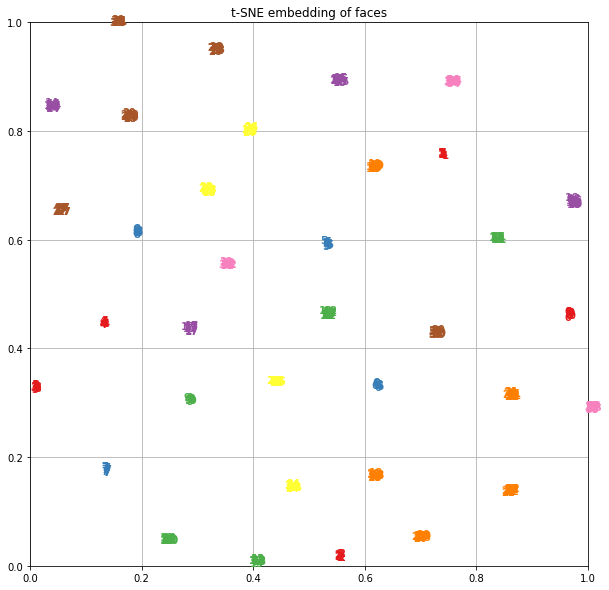

In [ ]:
fig = plot_embedding(reduced, train_labels.detach().numpy(),'t-SNE embedding of faces')
plt.savefig("t-SNE_visualization_of_embeddings.png")
plt.show(fig)

In [ ]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal

In [ ]:
train_dists = triplet_loss._pairwise_distances(train_embd)
train_dists.shape, train_dists.max(), train_dists.mean()

(torch.Size([350, 350]),
 tensor(1.8376, grad_fn=<MaxBackward1>),
 tensor(1.3862, grad_fn=<MeanBackward0>))

In [ ]:
mask = pairs_mask(train_labels)

In [ ]:
train_pairwise_dists = train_dists[mask]
train_pairwise_dists.shape

torch.Size([122150])

In [ ]:
train_Psame = torch.eq(train_labels.unsqueeze(0), train_labels.unsqueeze(1))
train_Psame_pairwise = train_Psame[mask]
train_Psame.shape, train_Psame_pairwise.shape

(torch.Size([350, 350]), torch.Size([122150]))

In [ ]:
val, far, precision, accuracy = calculate_metrics(0.91, train_pairwise_dists.detach().numpy(), train_Psame_pairwise.detach().numpy())
print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 1.0
False Accept Rate = 0.0
Precision = 1.0
Accuracy = 1.0


400it [00:00, 778.11it/s]


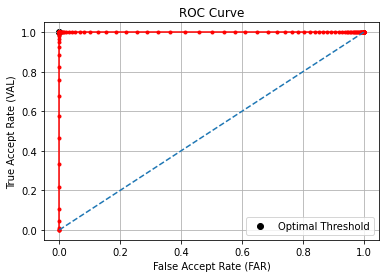

In [ ]:
best_threshold, tar, far, precision, accuracy = evaluate(train_pairwise_dists.detach().numpy(),
                                                         train_Psame_pairwise.detach().numpy(),
                                                         roc_curve=True)


In [ ]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 0.26
True Acceptance: 1.000
False Acceptance: 0.000
Precision: 1.000
Accuracy: 1.000


In [ ]:
preds = train_pairwise_dists < 0.32

In [ ]:
true_accepts  = np.logical_and(preds, train_Psame_pairwise)
false_accepts = np.logical_and(preds, train_Psame_pairwise.logical_not())
false_rejects = np.logical_and(torch.logical_not(preds), train_Psame_pairwise)
true_rejects  = np.logical_and(torch.logical_not(preds), train_Psame_pairwise.logical_not())

true_accepts.sum(), false_accepts.sum(), false_rejects.sum(), true_rejects.sum()

(tensor(3150), tensor(0), tensor(0), tensor(119000))

In [ ]:
VAL = true_accepts.sum()  / train_Psame_pairwise.sum() # true acceptance rate (tar, tpr, sensitivity)
FAR = false_accepts.sum() / train_Psame_pairwise.logical_not().sum() # false acceptance rate (fpr)
FRR = false_rejects.sum() / train_Psame_pairwise.sum() # false reject rate (fnr)
TRR = true_rejects.sum()  / train_Psame_pairwise.logical_not().sum() # true reject rate (tnr)

VAL, FAR, FRR, TRR

(tensor(1.), tensor(0.), tensor(0.), tensor(1.))

In [ ]:
vals = []
fars = []
frrs = []
trrs = []
precisions = []
gmeans = []
f1_scores = []
accuracies = []
youdens = []
x = np.arange(0, 4, 0.01)
for threshold in tqdm_notebook(x):
    val, far, precision, accuracy = calculate_metrics(threshold, train_pairwise_dists.detach().numpy(), train_Psame_pairwise.detach().numpy())
    youden = val - far

    vals.append(val)
    fars.append(far)
    precisions.append(precision)
    accuracies.append(accuracy)
    youdens.append(youden)

vals = np.asarray(vals)
fars = np.asarray(fars)
frrs = np.asarray(frrs)
trrs = np.asarray(trrs)
precisions = np.asarray(precisions)
gmeans = np.asarray(gmeans)
f1_scores = np.asarray(f1_scores)
youdens = np.asarray(youdens)

In [ ]:
p = np.argmax(precisions)
a = np.argmax(accuracies)
y = np.argmax(youdens)

In [ ]:
p,a,y

(3, 32, 32)

In [ ]:
precisions[p], accuracies[a], youdens[y], x[y]

(1.0, 1.0, 1.0, 0.32)

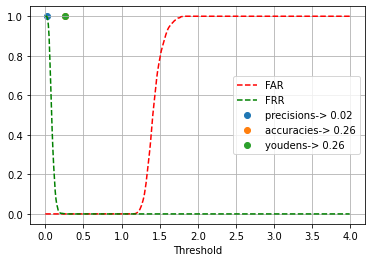

In [ ]:
plt.figure()
plt.plot(x, fars, 'r--', label='FAR')
plt.plot(x, 1-vals, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.scatter(x[p], precisions[p], label=f'precisions-> {x[p]}')
plt.scatter(x[a], accuracies[a], label=f'accuracies-> {x[a]}')
plt.scatter(x[y], youdens[y], label=f'youdens-> {x[y]}')
plt.legend()
plt.grid()
plt.show()

In [ ]:
preds = test_pairwise_dists < 0.32

In [ ]:
true_accepts  = np.logical_and(preds, test_Psame_pairwise)
false_accepts = np.logical_and(preds, test_Psame_pairwise.logical_not())
false_rejects = np.logical_and(torch.logical_not(preds), test_Psame_pairwise)
true_rejects  = np.logical_and(torch.logical_not(preds), test_Psame_pairwise.logical_not())

true_accepts.sum(), false_accepts.sum(), false_rejects.sum(), true_rejects.sum()

(tensor(3150), tensor(0), tensor(0), tensor(119000))

In [ ]:
VAL = true_accepts.sum()  / test_Psame_pairwise.sum() # true acceptance rate (tar, tpr, sensitivity)
FAR = false_accepts.sum() / test_Psame_pairwise.logical_not().sum() # false acceptance rate (fpr)
FRR = false_rejects.sum() / test_Psame_pairwise.sum() # false reject rate (fnr)
TRR = true_rejects.sum()  / test_Psame_pairwise.logical_not().sum() # true reject rate (tnr)

VAL, FAR, FRR, TRR

(tensor(1.), tensor(0.), tensor(0.), tensor(1.))

In [ ]:
vals = []
fars = []
frrs = []
trrs = []
precisions = []
gmeans = []
f1_scores = []
accuracies = []
youdens = []
x = np.arange(0, 4, 0.01)
for threshold in tqdm_notebook(x):
    val, far, precision, accuracy = calculate_metrics(threshold, test_pairwise_dists.detach().numpy(), test_Psame_pairwise.detach().numpy())
    youden = val - far

    vals.append(val)
    fars.append(far)
    precisions.append(precision)
    accuracies.append(accuracy)
    youdens.append(youden)

vals = np.asarray(vals)
fars = np.asarray(fars)
frrs = np.asarray(frrs)
trrs = np.asarray(trrs)
precisions = np.asarray(precisions)
gmeans = np.asarray(gmeans)
f1_scores = np.asarray(f1_scores)
youdens = np.asarray(youdens)

In [ ]:
p = np.argmax(precisions)
a = np.argmax(accuracies)
y = np.argmax(youdens)

In [ ]:
p,a,y

(3, 32, 32)

In [ ]:
precisions[p], accuracies[a], youdens[y], x[y]

(1.0, 1.0, 1.0, 0.32)

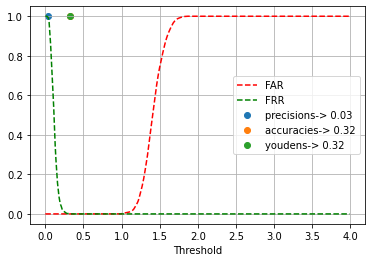

In [ ]:
plt.figure()
plt.plot(x, fars, 'r--', label='FAR')
plt.plot(x, 1-vals, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.scatter(x[p], precisions[p], label=f'precisions-> {x[p]}')
plt.scatter(x[a], accuracies[a], label=f'accuracies-> {x[a]}')
plt.scatter(x[y], youdens[y], label=f'youdens-> {x[y]}')
plt.legend()
plt.grid()
plt.show()

### Plotting False Accepts



In [ ]:
preds = train_dists < 0.32
false_accepts = np.logical_and(preds, train_Psame.logical_not())
false_accepts.shape

torch.Size([350, 350])

In [ ]:
false_accept_idxs =  (false_accepts == 1).nonzero(as_tuple=True)
len(false_accept_idxs)

2

In [ ]:
false_accept_idxs[0].shape

torch.Size([0])

In [ ]:
for idx in np.random.randint(0,7506, size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1,idx2 = false_accept_idxs[0][idx], false_accept_idxs[1][idx]

    i1.imshow(train_images[idx1].squeeze(), cmap='gray')
    i2.imshow(train_images[idx2].squeeze(), cmap='gray')
    i1.title.set_text(f'Classes: left={train_labels[idx1]} right={train_labels[idx2]}')
    i2.title.set_text(f'Distance: {train_dists[idx1][idx2]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

### Plotting Flase Rejects

In [ ]:
false_rejects = np.logical_and(torch.logical_not(preds), train_Psame)
false_rejects.shape

torch.Size([350, 350])

In [ ]:
false_rejects_idxs =  (false_rejects == 1).nonzero(as_tuple=True)
len(false_rejects_idxs)

2

In [ ]:
false_rejects_idxs[0].shape

torch.Size([0])

In [ ]:
for idx in np.random.randint(0,132, size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1,idx2 = false_rejects_idxs[0][idx], false_rejects_idxs[1][idx]

    i1.imshow(train_images[idx1].squeeze(), cmap='gray')
    i2.imshow(train_images[idx2].squeeze(), cmap='gray')
    i1.title.set_text(f'Classes: left={train_labels[idx1]} right={train_labels[idx2]}')
    i2.title.set_text(f'Distance: {train_dists[idx1][idx2]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

# Evaluation

In [ ]:
testing_data = DataLoader(test, batch_size=len(test))
test_images, test_labels = next(iter(testing_data))
test_images.shape, test_labels.shape

(torch.Size([50, 1, 224, 224]), torch.Size([50]))

In [ ]:
test_embd = resnet18(test_images.cuda()).cpu()
test_embd.shape

torch.Size([50, 64])

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(test_embd.detach().numpy())

In [ ]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 5.),
                 fontdict={'weight': 'bold', 'size': 10})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(alpha=0.5)
    plt.title(title)
    return fig

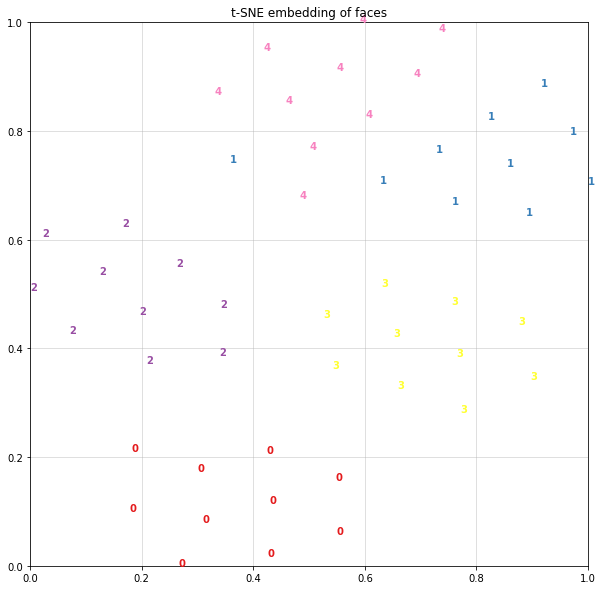

In [ ]:
fig = plot_embedding(reduced, test_labels.detach().numpy(),'t-SNE embedding of faces')
plt.show(fig)
# plt.savefig("t-SNE_visualization_of_test_embeddings.png")

In [ ]:
test_dists = triplet_loss._pairwise_distances(test_embd)
test_dists.shape, test_dists.max(), test_dists.mean()

(torch.Size([50, 50]),
 tensor(1.6339, grad_fn=<MaxBackward1>),
 tensor(1.1691, grad_fn=<MeanBackward0>))

In [ ]:
mask = pairs_mask(test_labels)

In [ ]:
test_pairwise_dists = test_dists[mask]
test_pairwise_dists.shape

torch.Size([2450])

In [ ]:
test_Psame = torch.eq(test_labels.unsqueeze(0), test_labels.unsqueeze(1))
test_Psame_pairwise = test_Psame[mask]
test_Psame.shape, test_Psame_pairwise.shape

(torch.Size([50, 50]), torch.Size([2450]))

In [ ]:
val, far, precision, accuracy = calculate_metrics(0.89, test_pairwise_dists.detach().numpy(), test_Psame_pairwise.detach().numpy())
print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.9777777777777777
False Accept Rate = 0.015
Precision = 0.9361702127659575
Accuracy = 0.9836734693877551


In [ ]:
val, far, precision, accuracy = calculate_metrics(0.91, test_pairwise_dists.detach().numpy(), test_Psame_pairwise.detach().numpy())
print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.9777777777777777
False Accept Rate = 0.023
Precision = 0.9053497942386831
Accuracy = 0.9771428571428571


400it [00:00, 11008.24it/s]


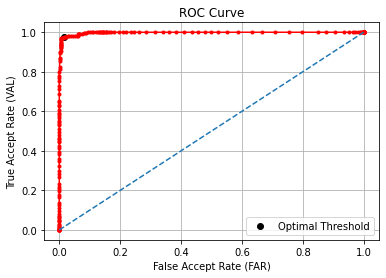

In [ ]:
best_threshold, tar, far, precision, accuracy = evaluate(test_pairwise_dists.detach().numpy(),
                                                         test_Psame_pairwise.detach().numpy(),
                                                         roc_curve=True)


In [ ]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 0.89
True Acceptance: 0.978
False Acceptance: 0.015
Precision: 0.936
Accuracy: 0.984


In [ ]:
vals = []
fars = []
frrs = []
trrs = []
precisions = []
gmeans = []
f1_scores = []
accuracies = []
youdens = []
x = np.arange(0, 4, 0.01)
for threshold in tqdm_notebook(x):
    val, far, precision, accuracy = calculate_metrics(threshold, test_pairwise_dists.detach().numpy(), test_Psame_pairwise.detach().numpy())
    youden = val - far
    gmean = np.sqrt(val* (1-far))
    youden = val - far
    f1_score = 2 * (precision * val) / (precision + val + 1e-16)

    vals.append(val)
    fars.append(far)
    precisions.append(precision)
    accuracies.append(accuracy)
    youdens.append(youden)
    gmeans.append(gmean)
    f1_scores.append(f1_score)


vals = np.asarray(vals)
fars = np.asarray(fars)
frrs = np.asarray(frrs)
trrs = np.asarray(trrs)
precisions = np.asarray(precisions)
gmeans = np.asarray(gmeans)
f1_scores = np.asarray(f1_scores)
youdens = np.asarray(youdens)

In [ ]:
p = np.argmax(precisions)
a = np.argmax(accuracies)
y = np.argmax(youdens)
f = np.argmax(f1_scores)
g = np.argmax(gmeans)

In [ ]:
p,a,y, f, g

(6, 85, 89, 85, 89)

In [ ]:
precisions[p], accuracies[a], youdens[y], f1_scores[f], gmeans[g], x[y]

(1.0,
 0.9885714285714285,
 0.9627777777777777,
 0.9688888888888889,
 0.9813822451578748,
 0.89)

In [ ]:
np.argmin(abs((1-vals) - fars))

91

In [ ]:
x[91]

0.91

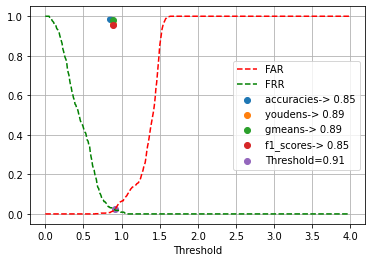

In [ ]:
plt.figure()
plt.plot(x, fars, 'r--', label='FAR')
plt.plot(x, 1-vals, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.scatter(x[a], accuracies[a], label=f'accuracies-> {x[a]}')
plt.scatter(x[y], youdens[y], label=f'youdens-> {x[y]}')
plt.scatter(x[y], gmeans[y], label=f'gmeans-> {x[g]}')
plt.scatter(x[y], f1_scores[y], label=f'f1_scores-> {x[f]}')
plt.scatter(0.91, fars[91],label="Threshold=0.91")
plt.legend()
plt.grid()
plt.show()

### Plotting False Accepts



In [ ]:
preds = test_dists < 0.89
false_accepts = np.logical_and(preds, test_Psame.logical_not())
false_accepts.shape

torch.Size([50, 50])

In [ ]:
false_accept_idxs =  (false_accepts == 1).nonzero(as_tuple=True)
len(false_accept_idxs)

2

In [ ]:
false_accept_idxs

(tensor([10, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 40, 40, 42,
         42, 43, 43, 44, 44, 44, 46, 46, 48, 48, 48, 48]),
 tensor([44, 48, 40, 42, 43, 44, 46, 48, 40, 42, 43, 44, 46, 48, 48, 12, 13, 12,
         13, 12, 13, 10, 12, 13, 12, 13, 11, 12, 13, 14]))

In [ ]:
false_accept_idxs[0].shape

torch.Size([30])

0


<Figure size 432x288 with 0 Axes>

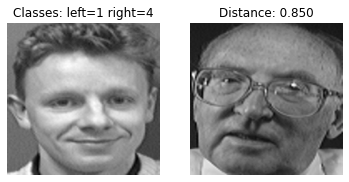

1


<Figure size 432x288 with 0 Axes>

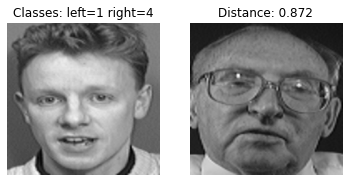

2


<Figure size 432x288 with 0 Axes>

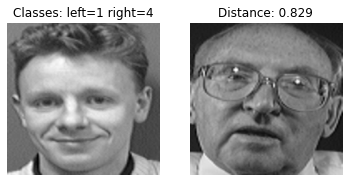

3


<Figure size 432x288 with 0 Axes>

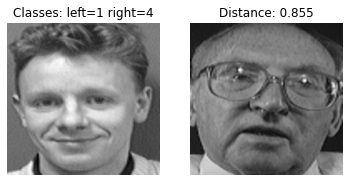

4


<Figure size 432x288 with 0 Axes>

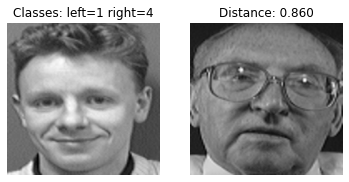

5


<Figure size 432x288 with 0 Axes>

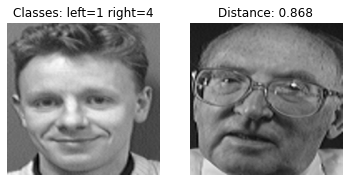

6


<Figure size 432x288 with 0 Axes>

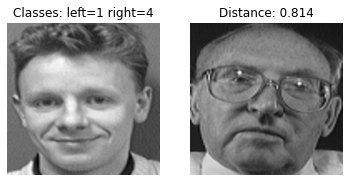

7


<Figure size 432x288 with 0 Axes>

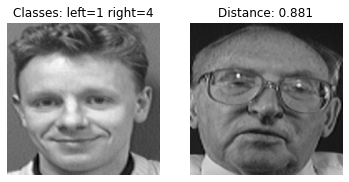

8


<Figure size 432x288 with 0 Axes>

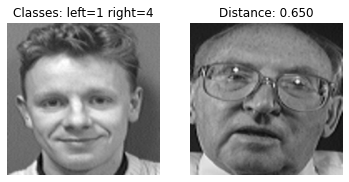

9


<Figure size 432x288 with 0 Axes>

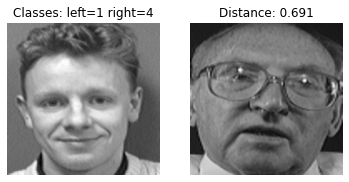

10


<Figure size 432x288 with 0 Axes>

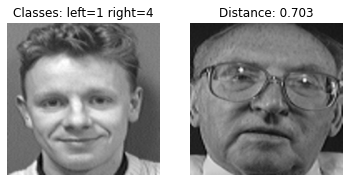

11


<Figure size 432x288 with 0 Axes>

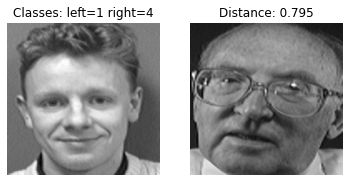

12


<Figure size 432x288 with 0 Axes>

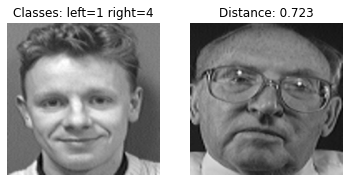

13


<Figure size 432x288 with 0 Axes>

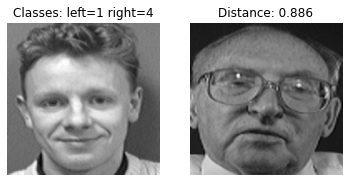

14


<Figure size 432x288 with 0 Axes>

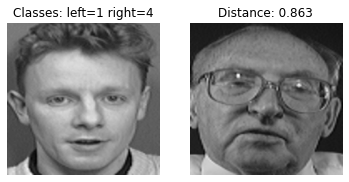

In [ ]:
# for idx in np.random.randint(0,30, size=30):
for idx in range(15):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1,idx2 = false_accept_idxs[0][idx], false_accept_idxs[1][idx]

    i1.imshow(test_images[idx1].squeeze(), cmap='gray')
    i2.imshow(test_images[idx2].squeeze(), cmap='gray')
    i1.title.set_text(f'Classes: left={test_labels[idx1]} right={test_labels[idx2]}')
    i2.title.set_text(f'Distance: {test_dists[idx1][idx2]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

### Plotting Flase Rejects

In [ ]:
false_rejects = np.logical_and(torch.logical_not(preds), test_Psame)
false_rejects.shape

torch.Size([50, 50])

In [ ]:
false_rejects_idxs =  (false_rejects == 1).nonzero(as_tuple=True)
len(false_rejects_idxs)

2

In [ ]:
false_rejects_idxs[0].shape

torch.Size([10])

0


<Figure size 432x288 with 0 Axes>

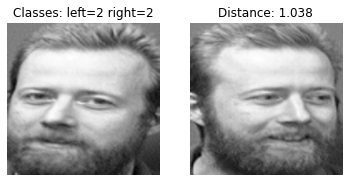

1


<Figure size 432x288 with 0 Axes>

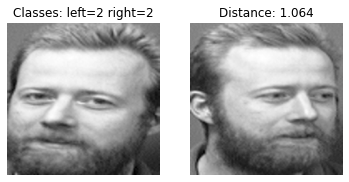

2


<Figure size 432x288 with 0 Axes>

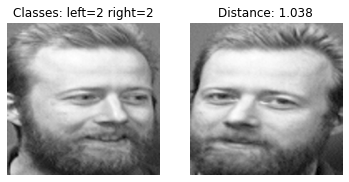

3


<Figure size 432x288 with 0 Axes>

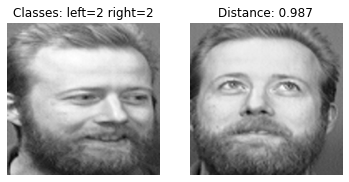

4


<Figure size 432x288 with 0 Axes>

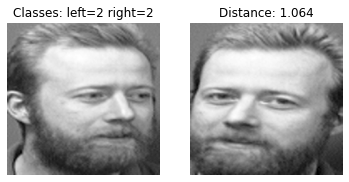

In [ ]:
# for idx in np.random.randint(0,38, size=30):
for idx in range(5):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1,idx2 = false_rejects_idxs[0][idx], false_rejects_idxs[1][idx]

    i1.imshow(test_images[idx1].squeeze(), cmap='gray')
    i2.imshow(test_images[idx2].squeeze(), cmap='gray')
    i1.title.set_text(f'Classes: left={test_labels[idx1]} right={test_labels[idx2]}')
    i2.title.set_text(f'Distance: {test_dists[idx1][idx2]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

In [ ]:
wandb.finish()

loss,0.25303
fraction_of_positive_triplets,0.13807
_runtime,1366
_timestamp,1621763179
_step,109
epoch_loss,0.0104


loss,█▆▄▄▄▃▃▄▃▃▃▃▃▃▃▃▂▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁
fraction_of_positive_triplets,█▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂


# Sweeps

In [ ]:
import wandb

### Define Sweep

In [ ]:
sweep_config = {
    'method': 'random' # grid, random, bayes
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [ ]:
parameter_dict = {
    'fc_layer_size': {
        'values': [64, 128, 256]
    },
    'learning_rate': {
        'values': [0.001, 0.002,  0.0002, 0.0001]
    },
    'batch_size': {
        'values': [40,100]
    },
    'epochs': {
        'values': [10,50,100]
    }
}
sweep_config['parameters'] = parameter_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [40, 100]},
                'epochs': {'values': [10, 50, 100]},
                'fc_layer_size': {'values': [64, 128, 256]},
                'learning_rate': {'values': [0.001, 0.002, 0.0002, 0.0001]}}}


### Initialize Sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='Face-Unlock')

Create sweep with ID: vq62ojvw
Sweep URL: https://wandb.ai/abd1/Face-Unlock/sweeps/vq62ojvw


In [ ]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal

In [ ]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'batch_size': 100,
        'epochs': 20,
        'fc_layer_size': 128,
        'learning_rate': 0.001,
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # define model
    network = ResNet(num_classes=config.fc_layer_size)
    network.to(device)
    # train loader 
    loader = DataLoader(train_data, batch_size = config.batch_size, shuffle=True)
    # optimizer
    optimizer = optim.Adam(network.parameters(), lr=config.learning_rate)

    network.train()
    network = network.to(device)
    for epoch in range(config.epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            embds = network(images.to(device)).to('cpu')
            loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt}, commit=False)
            loss.backward()
            optimizer.step()

            mask = pairs_mask(labels)
            Psame = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))[mask]
            dists = triplet_loss._pairwise_distances(embds)[mask]
            best_threshold, tar, far, precision, accuracy = evaluate(dists.detach().numpy(), Psame.detach().numpy())
            wandb.log({"best_threshold":best_threshold,
                      "True Acceptance Rate": tar,
                      "False Acceptace Rate": far,
                      "Accuracy":accuracy})

        wandb.log({"epoch_loss": epoch_loss / config.batch_size})


### Run sweep Agent

In [ ]:
sweep_id = 'vq62ojvw'
wandb.agent(sweep_id, train, count=1)

In [ ]:
wandb.finish()